<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/MDF/blob/main/MDF_Transporte_de_esp%C3%A9cies_com_Navier_Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

Lx, Ly, Tmax = 10.0, 0.12, 20.0
Nx, Ny, Nt = 100, 20, 10000 #o motivo para ter um NT enorme é porque com valores menores, o codigo apresenta overflow
dx, dy, dt = Lx / (Nx - 1), Ly / (Ny - 1), Tmax / Nt
x, y = np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

rho = 1000.0 #densidade da água
mu = 1e-3 #viscosidade dinâmica da água
alpha = mu / rho
D = 7.48e-3 #difusão

u = np.zeros((Ny, Nx)) #velocidade x
v = np.zeros((Ny, Nx)) #velocidade y
p = np.zeros((Ny, Nx)) #pressão
c = np.zeros((Ny, Nx)) #concentração MEG

iu, iv = 2.21, 0#velocidade inicial da água em x e em y
u[:, :] = iu
x_inj_index = int(2.0 / dx)#pontos de injeção de MEG
vel_inj_meg = 5e-3#velocidade da injeção de meg

def solve_navier_stokes(u, v, p, rho, mu, dt, dx, dy):
  un, vn, pn = u.copy(), v.copy(), p.copy()
  dpdx = (pn[:, 2:] - pn[:, :-2]) / (2 * dx)
  dpdy = (pn[2:, :] - pn[:-2, :]) / (2 * dy)

  lapu = (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, :-2]) / dx ** 2 + \
       (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[:-2, 1:-1]) / dy ** 2
  lapv = (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, :-2]) / dx ** 2 + \
       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[:-2, 1:-1]) / dy ** 2

  u[1:-1, 1:-1] = un[1:-1, 1:-1] - dt / rho * dpdx[1:-1, :] + alpha * dt * lapu
  v[1:-1, 1:-1] = vn[1:-1, 1:-1] - dt / rho * dpdy[:, 1:-1] + alpha * dt * lapv

  return u, v

results = []
save_steps = [0, int(0.25 * Nt), int(0.5 * Nt), int(0.75 * Nt), Nt - 1] #fazer uma plotagem em diferentes instantes de tempo

#Código MDF
for n in range(Nt):
  u, v = solve_navier_stokes(u, v, p, rho, mu, dt, dx, dy)
  c_new = c.copy()
  for j in range(1, Ny - 1):
    for i in range(1, Nx - 1):
      adv_x = -u[j, i] * (c[j, i] - c[j, i - 1]) / dx
      adv_y = -v[j, i] * (c[j, i] - c[j - 1, i]) / dy
      diff_x = D * (c[j, i + 1] - 2 * c[j, i] + c[j, i - 1]) / dx ** 2
      diff_y = D * (c[j + 1, i] - 2 * c[j, i] + c[j - 1, i]) / dy ** 2
      c_new[j, i] += dt * (adv_x + adv_y + diff_x + diff_y)

  c_new[:, 0] = 0.0
  c_new[:, -1] = c_new[:, -2]
  c_new[0, :] = c_new[1, :]
  c_new[-1, :] = c_new[-2, :]

  c_new[0, x_inj_index] = 1.0#O de cima é condição de contorno, aqui é a injeção de meg
  c_new[-1, x_inj_index] = 1.0

  c = c_new.copy()

  if n in save_steps:
    results.append(c.copy())

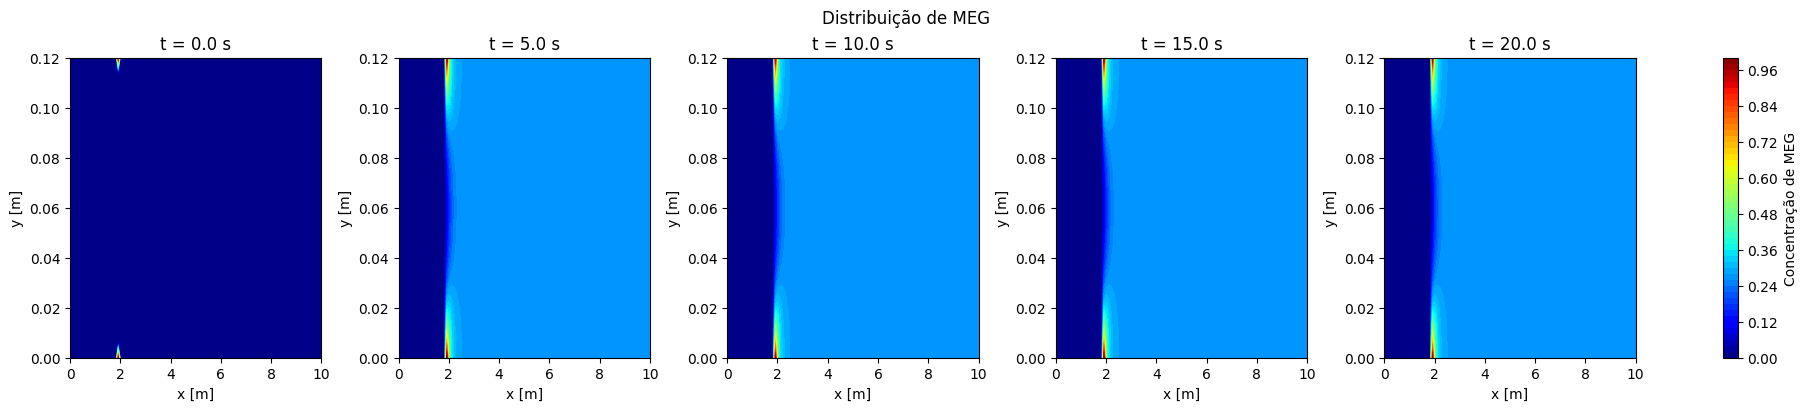

In [ ]:
fig, axes = plt.subplots(1, len(results), figsize=(18, 4), constrained_layout=True)
for idx, ax in enumerate(axes):
  cf = ax.contourf(X, Y, results[idx], levels=50, cmap='jet')
  ax.set_title(f"t = {save_steps[idx]*dt:.1f} s")
  ax.set_xlabel("x [m]")
  ax.set_ylabel("y [m]")
fig.colorbar(cf, ax=axes.ravel().tolist(), label='Concentração de MEG')
plt.suptitle("Distribuição de MEG")
plt.show()

In [1]:
#Imports
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import optax

N_b = 200
N_r = 15000

ymin, ymax = 0., 0.12
xmin, xmax = 0., 10.
tmin, tmax = 0., 10.

lb = jnp.array([xmin, ymin, tmin])
ub = jnp.array([xmax, ymax, tmax])

T = 352.89 #K
v = 2.21 #m/s
psimeg = 2.6 #parametro do solvente
Mmeg = 1.98+2*5.48 #Peso molecular do meg, em g/mol
mi = 0.891 #Viscosidade da solução, centipoises
Va = 55.7582 #Volume molar do soluto, em cm³/g*mol
Difu = 7.4e-8 *((np.sqrt(psimeg*Mmeg)*T)/(mi*Va**0.6))
rhoagua = 1000
rhomeg = 1200
visccinagua = 0.89e-3
visccinmeg = 16.1e-3

b01, bk1, bk2, bk3, bk4, r0k, r1k, r2k = jax.random.split(jax.random.PRNGKey(0),8)

#Condição inicial
# Funções para definir condições iniciais e de contorno
def c_contorno(t, x, y):
  c_meg = jnp.zeros_like(x)
  c_agua = jnp.ones_like(x)
  u_agua = jnp.ones_like(x)*2.21
  v_agua = jnp.zeros_like(x)
  p_agua = jnp.ones_like(x)*10.0
  return c_meg, u_agua, v_agua, p_agua

def c_inicial(x, y):
  c_meg = jnp.zeros_like(x)
  c_agua = jnp.ones_like(x)
  u_agua = jnp.ones_like(x)*2.21
  v_agua = jnp.zeros_like(x)
  p_agua = jnp.ones_like(x)*10.0
  return c_meg, u_agua

def injecao(t, x, y):
  c_meg_inj = jnp.where(yinj == 0.0, 1.0, 0.0) + jnp.where(yinj == 0.12, 1.0, 0.0)
  c_agua_inj = 1.0 - c_meg_inj
  u_agua_inj = jnp.ones_like(x) * 5e-3
  v_agua_inj = jnp.ones_like(x) * 0.
  p_agua_inj = jnp.ones_like(x) * 7.0
  return c_meg_inj, u_agua_inj, v_agua_inj, p_agua_inj

# Geração dos pontos de condição inicial
x0 = jax.random.uniform(jax.random.PRNGKey(0), (N_b, 1), minval=lb[0], maxval=ub[0])
y0 = jax.random.uniform(jax.random.PRNGKey(1), (N_b, 1), minval=lb[1], maxval=ub[1])
t0 = jnp.zeros((N_b, 1))
c0meg, u0 = c_inicial(x0, y0)
espaco0 = jnp.concatenate([x0, y0, t0], axis=1)

# Geração dos pontos de contorno x=0
tbx1 = jax.random.uniform(jax.random.PRNGKey(2), (N_b, 1), minval=lb[2], maxval=ub[2])
xbx1 = jnp.zeros((N_b, 1))
ybx1 = jax.random.uniform(jax.random.PRNGKey(3), (N_b, 1), minval=lb[1], maxval=ub[1])
c_contxmeg, uc, vc, pc = c_contorno(tbx1, xbx1, ybx1)
espacobx1 = jnp.concatenate([xbx1, ybx1, tbx1], axis=1)

# Geração dos pontos de contorno x=1
tbx2 = jax.random.uniform(jax.random.PRNGKey(4), (N_b, 1), minval=lb[2], maxval=ub[2])
xbx2 = jnp.ones((N_b, 1)) * ub[0]
ybx2 = jax.random.uniform(jax.random.PRNGKey(5), (N_b, 1), minval=lb[1], maxval=ub[1])
espacobx2 = jnp.concatenate([xbx2, ybx2, tbx2], axis=1)

# Geração dos pontos de contorno y=0
tby1 = jax.random.uniform(jax.random.PRNGKey(6), (N_b, 1), minval=lb[2], maxval=ub[2])
xby1 = jax.random.uniform(jax.random.PRNGKey(7), (N_b, 1), minval=lb[0], maxval=ub[0])
yby1 = jnp.zeros((N_b, 1))
espacoby1 = jnp.concatenate([xby1, yby1, tby1], axis=1)

# Geração dos pontos de contorno y=1
tby2 = jax.random.uniform(jax.random.PRNGKey(8), (N_b, 1), minval=lb[2], maxval=ub[2])
xby2 = jax.random.uniform(jax.random.PRNGKey(9), (N_b, 1), minval=lb[0], maxval=ub[0])
yby2 = jnp.ones((N_b, 1)) * ub[1]
espacoby2 = jnp.concatenate([xby2, yby2, tby2], axis=1)

#injeção de meg
tinj = jax.random.uniform(jax.random.PRNGKey(10), (N_b, 1), minval=lb[2], maxval=ub[2])
xinj = jnp.ones((N_b, 1)) * 2.0
yinj = 0.0 + jax.random.bernoulli(jax.random.PRNGKey(11), p=0.5, shape=(N_b, 1)) * 0.12
espacoinj = jnp.concatenate([xinj, yinj, tinj], axis=1)
c_meg_inj, ui, vi, pi = injecao(tinj, xinj, yinj)

#collocation points
t_c = jax.random.uniform(r0k,minval=tmin,maxval=tmax,shape=(N_r,1))
y_c = jax.random.uniform(r1k,minval=ymin,maxval=ymax,shape=(N_r,1))
x_c = jax.random.uniform(r2k,minval=xmin,maxval=xmax,shape=(N_r,1))
colloc = jnp.concatenate([x_c,y_c, t_c],axis=1)

def PDE_loss(x, y, t, c_meg, u, v, p):
  c_meg_x=lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(c_meg(x,y,t)),0)(x,y,t)
  c_meg_xx=lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(c_meg_x(x,y,t)),0)(x,y,t)

  c_meg_y=lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(c_meg(x,y,t)),1)(x,y,t)
  c_meg_yy=lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(c_meg_y(x,y,t)),1)(x,y,t)

  c_meg_t = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(c_meg(x,y,t)),2)(x,y,t)

  u_x = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(u(x,y,t)),0)(x,y,t)
  u_xx = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(u_x(x,y,t)),0)(x,y,t)

  u_y = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(u(x,y,t)),1)(x,y,t)
  u_yy = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(u_y(x,y,t)),1)(x,y,t)

  u_t = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(u(x,y,t)),2)(x,y,t)

  v_x = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(v(x,y,t)),0)(x,y,t)
  v_xx = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(v_x(x,y,t)),0)(x,y,t)

  v_y = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(v(x,y,t)),1)(x,y,t)
  v_yy = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(v_y(x,y,t)),1)(x,y,t)

  v_t = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(v(x,y,t)),2)(x,y,t)

  p_x = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(p(x,y,t)),0)(x,y,t)

  p_y = lambda x,y,t:jax.grad(lambda x,y,t:jnp.sum(p(x,y,t)),1)(x,y,t)

  continuity = u_x(x,y,t) + v_y(x,y,t)
  momentum_x = u_t(x,y,t) + u(x,y,t)* u_x(x,y,t) + v(x,y,t) * u_y(x,y,t) + p_x(x,y,t)/((1-c_meg(x,y,t))*rhoagua + rhomeg*c_meg(x,y,t)) - ((1-c_meg(x,y,t))*visccinagua + visccinmeg*c_meg(x,y,t)) * (u_xx(x,y,t) + u_yy(x,y,t))
  momentum_y = v_t(x,y,t) + u(x,y,t)* v_x(x,y,t) + v(x,y,t) * v_y(x,y,t) + p_y(x,y,t)/((1-c_meg(x,y,t))*rhoagua + rhomeg*c_meg(x,y,t)) - ((1-c_meg(x,y,t))*visccinagua + visccinmeg*c_meg(x,y,t)) * (v_xx(x,y,t) + v_yy(x,y,t))
  transport = c_meg_t(x,y,t) + u(x,y,t)*(c_meg_x(x,y,t)) + v(x,y,t)*(c_meg_y(x,y,t)) -Difu*(c_meg_xx(x,y,t) + c_meg_yy(x,y,t))

  return continuity + momentum_x + momentum_y + transport

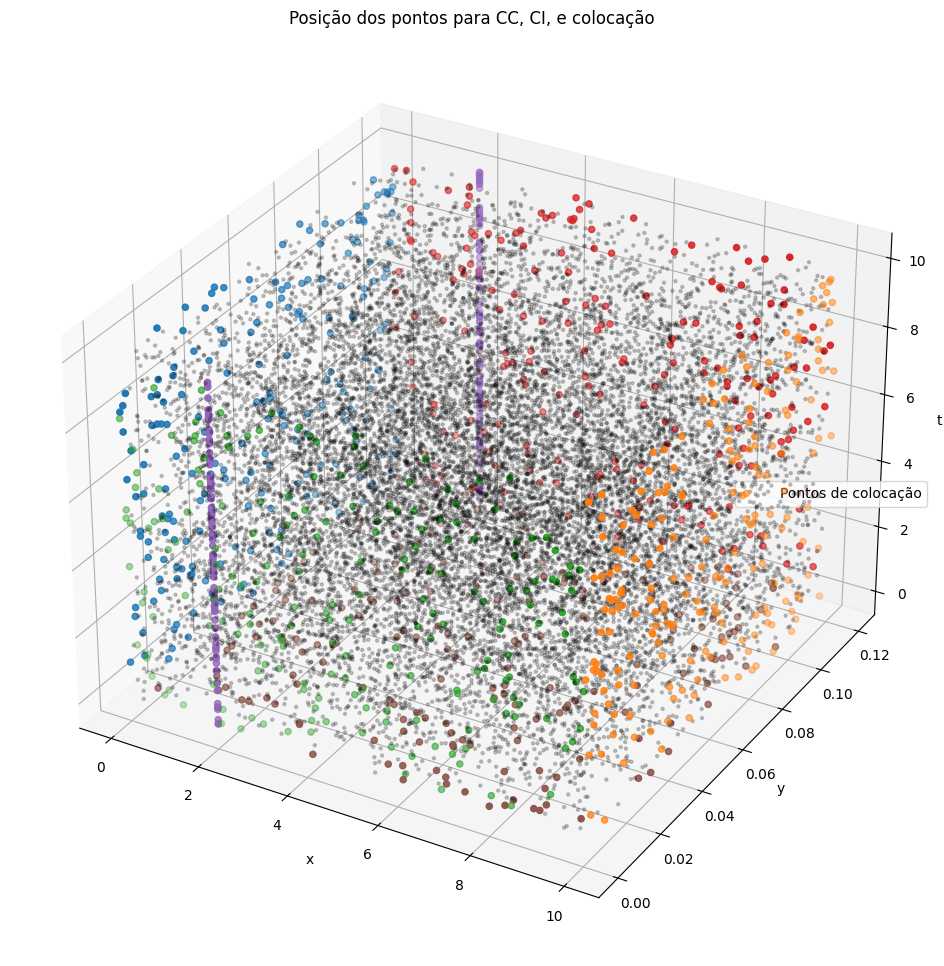

In [2]:
# Configuração da figura 3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
# Gráficos de dispersão para as diferentes condições de contorno e pontos de colocation
scatter1 = ax.scatter(xbx1, ybx1, tbx1)
scatter2 = ax.scatter(xbx2, ybx2, tbx2)
scatter3 = ax.scatter(xby1, yby1, tby1)
scatter4 = ax.scatter(xby2, yby2, tby2)
scatter4 = ax.scatter(xinj, yinj, tinj)
scatter0 = ax.scatter(x0,y0,t0)

# Pontos de colocation em preto
ax.scatter(x_c, y_c, t_c, c='k', marker='.', alpha=0.2, label='Pontos de colocação')

# Ajustes do gráfico
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
ax.set_title('Posição dos pontos para CC, CI, e colocação')

# Barra de cores e legenda
norm = mpl.colors.Normalize(vmin=0, vmax=1)
ax.legend(loc='center right')

plt.show()

In [7]:
def init_params(layers):
  keys = jax.random.split(jax.random.PRNGKey(30),len(layers)-1)
  params = list()
  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):
    lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in)) # xavier initialization lower and upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))
    B = jax.random.uniform(key,shape=(n_out,))
    params.append({'W':W,'B':B})
  return params

def fwd(params, x, y, t):
  # Concatenar t, x e y para formar o input da rede
  X = jnp.concatenate([x, y, t], axis=1)
  *hidden, last = params
  for layer in hidden:
    X = jax.nn.tanh(X @ layer['W'] + layer['B'])
  return X @ last['W'] + last['B']

@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)


def loss_fun(params,colloc,espaco0, espacobx1, espacobx2, espacoby1, espacoby2, c_contxmeg, c0meg, espacoinj, c_meg_inj, u0, uc, vc, pc, ui, vi, pi):
  x_c, y_c, t_c = colloc[:,[0]], colloc[:,[1]], colloc[:,[2]]
  c_meg, u, v, p = lambda x,y,t : fwd(params,x,y,t)[:,[0]], lambda x,y,t : fwd(params,x,y,t)[:,[1]], lambda x,y,t : fwd(params,x,y,t)[:,[2]], lambda x,y,t : fwd(params,x,y,t)[:,[3]]

  c_meg_x = lambda x,y,t : jax.grad(lambda x,y,t:jnp.sum(c_meg(x,y,t)),0)(x,y,t)
  c_meg_y = lambda x,y,t : jax.grad(lambda x,y,t:jnp.sum(c_meg(x,y,t)),1)(x,y,t)

  loss =jnp.mean(PDE_loss(x_c, y_c, t_c, c_meg, u, v, p) **2)

  loss += MSE(c_meg(espaco0[:,[0]], espaco0[:,[1]], espaco0[:,[2]]), c0meg)
  loss += MSE(c_meg(espacoinj[:,[0]], espacoinj[:,[1]], espacoinj[:,[2]]), c_meg_inj)
  loss += MSE(c_meg(espacobx1[:,[0]], espacobx1[:,[1]], espacobx1[:,[2]]),c_contxmeg)
  #loss += MSE(c_meg_x(espacobx2[:,[0]], espacobx2[:,[1]], espacobx2[:,[2]]), jnp.zeros_like(c_meg_x(espacobx2[:,[0]], espacobx2[:,[1]], espacobx2[:,[2]])))
  #loss += MSE(c_meg_y(espacoby1[:,[0]], espacoby1[:,[1]], espacoby1[:,[2]]), jnp.zeros_like(c_meg_y(espacoby1[:,[0]], espacoby1[:,[1]], espacoby1[:,[2]])))

  return  loss

@jax.jit
def update(opt_state,params,colloc,espaco0, espacobx1, espacobx2, espacoby1, espacoby2, c_contxmeg, c0meg, espacoinj, c_meg_inj, u0, uc, vc, pc, ui, vi, pi):
  # Get the gradient w.r.t to MLP params
  grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,espaco0, espacobx1, espacobx2, espacoby1, espacoby2, c_contxmeg, c0meg, espacoinj, c_meg_inj, u0, uc, vc, pc, ui, vi, pi)

  #Update params
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return opt_state,params

In [8]:
params = init_params([3]+[64]*6+[4]) #4 +sáidas, sendo c_meg, u, v, p

lr = 0.001
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

In [9]:
epochs = 10000
for i in range(epochs):
  opt_state,params = update(opt_state,params,colloc,espaco0, espacobx1, espacobx2, espacoby1, espacoby2, c_contxmeg, c0meg, espacoinj, c_meg_inj, u0, uc, vc, pc, ui, vi, pi)

  # print loss and epoch info
  if i %(100) ==0:
    print(f'Epoch={i}\tloss={loss_fun(params,colloc,espaco0, espacobx1, espacobx2, espacoby1, espacoby2, c_contxmeg, c0meg, espacoinj, c_meg_inj, u0, uc, vc, pc, ui, vi, pi):.3e}')

Epoch=0	loss=6.675e-01
Epoch=100	loss=4.089e-02
Epoch=200	loss=2.138e-02
Epoch=300	loss=1.374e-02
Epoch=400	loss=8.391e-03
Epoch=500	loss=6.019e-03
Epoch=600	loss=4.411e-03
Epoch=700	loss=2.697e-02
Epoch=800	loss=1.487e-03
Epoch=900	loss=2.392e-02
Epoch=1000	loss=4.048e-04
Epoch=1100	loss=2.393e-04
Epoch=1200	loss=2.963e-04
Epoch=1300	loss=1.502e-04
Epoch=1400	loss=3.021e-04
Epoch=1500	loss=1.194e-04
Epoch=1600	loss=7.567e-04
Epoch=1700	loss=1.009e-04
Epoch=1800	loss=1.407e-04
Epoch=1900	loss=9.131e-05
Epoch=2000	loss=7.695e-05
Epoch=2100	loss=9.591e-05
Epoch=2200	loss=6.892e-05
Epoch=2300	loss=5.981e-05
Epoch=2400	loss=6.630e-05
Epoch=2500	loss=5.367e-05
Epoch=2600	loss=2.901e-04
Epoch=2700	loss=1.825e-03
Epoch=2800	loss=4.472e-05
Epoch=2900	loss=6.089e-05
Epoch=3000	loss=3.766e-05
Epoch=3100	loss=4.050e-05


KeyboardInterrupt: 

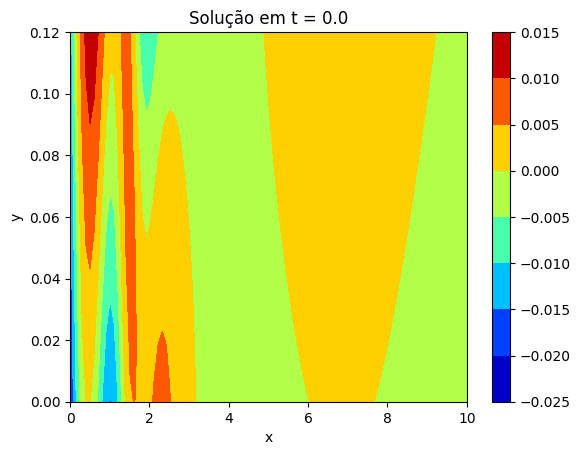

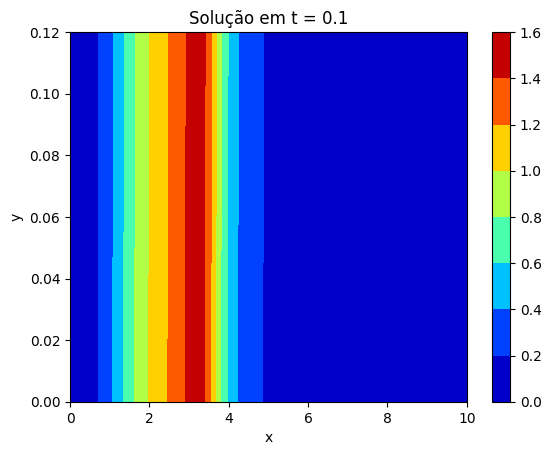

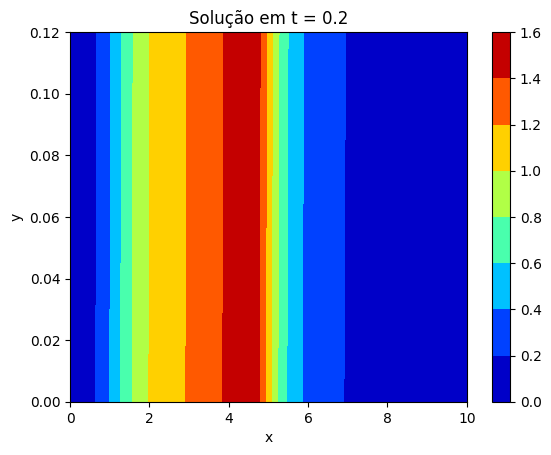

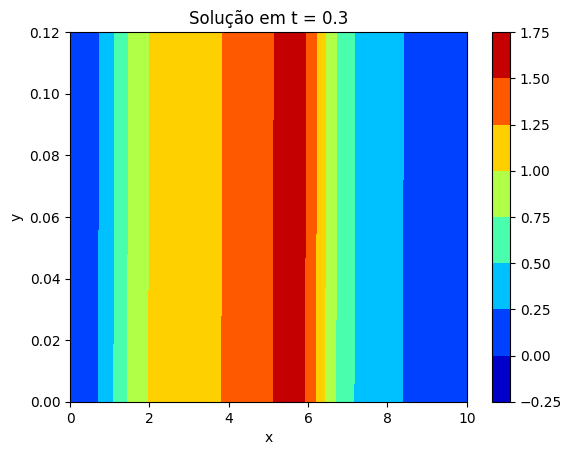

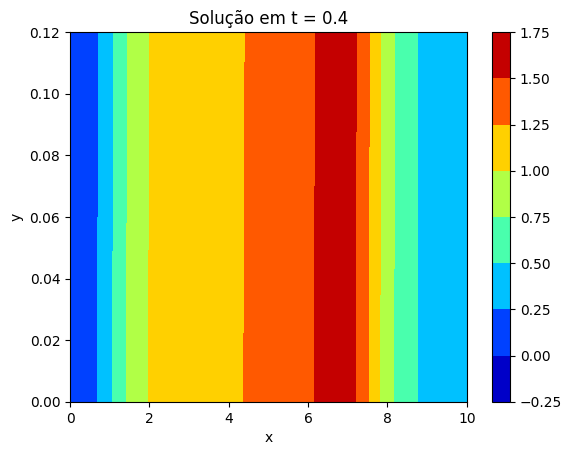

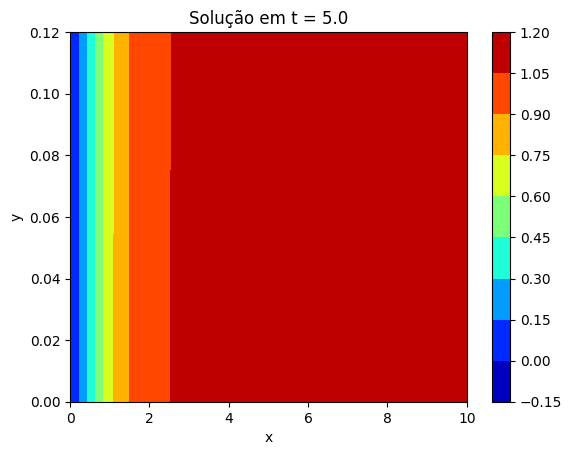

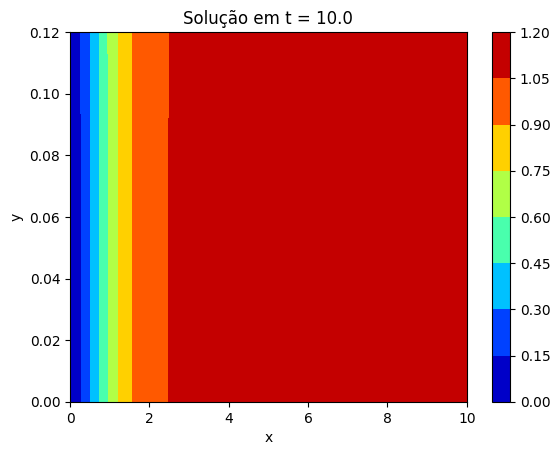

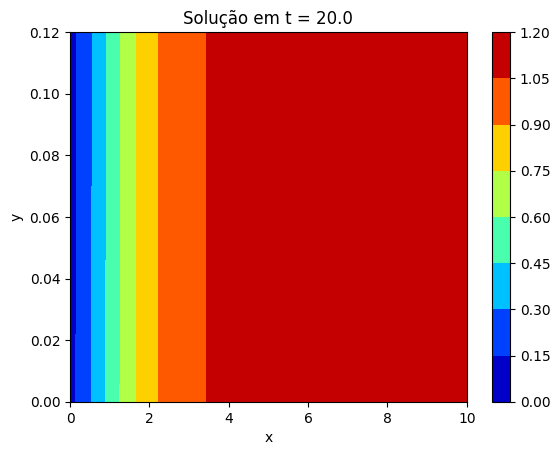

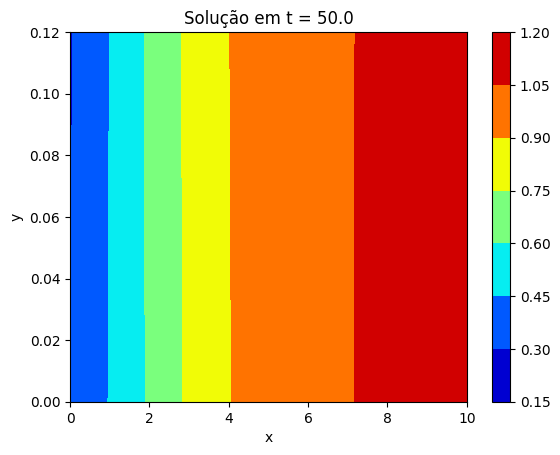

In [11]:
import numpy as np

# Definir uma função para avaliar a rede em diferentes instantes de tempo
def evaluate_solution(params, t_values, x_range, y_range, num_points=100):
    x = np.linspace(x_range[0], x_range[1], num_points)
    y = np.linspace(y_range[0], y_range[1], num_points)
    X, Y = np.meshgrid(x, y)

    for t in t_values:
        T = np.full_like(X, t)  # Criar um array de tempo fixo
        input_data = np.column_stack([T.flatten(), X.flatten(), Y.flatten()])
        output = fwd(params, input_data[:, [1]], input_data[:, [2]], input_data[:, [0]])[:,[0]]  # Avaliar a rede
        solution = output.reshape(X.shape)

        # Plotar a solução (opcional)
        plt.figure()
        plt.contourf(X, Y, solution, cmap='jet')
        plt.colorbar()
        plt.title(f'Solução em t = {t}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

# Avaliar a solução para instantes de tempo
evaluate_solution(params, t_values=[0.0, 0.1, 0.2, 0.3, 0.4, 5.0, 10.0, 20.0, 50.0], x_range=(0, 10), y_range=(0, 0.12))

In [ ]:
import numpy as np

# Definir uma função para avaliar a rede em diferentes instantes de tempo
def evaluate_solution(params, t_values, x_range, y_range, num_points=100):
    x = np.linspace(x_range[0], x_range[1], num_points)
    y = np.linspace(y_range[0], y_range[1], num_points)
    X, Y = np.meshgrid(x, y)

    for t in t_values:
        T = np.full_like(X, t)  # Criar um array de tempo fixo
        input_data = np.column_stack([T.flatten(), X.flatten(), Y.flatten()])
        output = fwd(params, input_data[:, [1]], input_data[:, [2]], input_data[:, [0]])[:,[0]]  # Avaliar a rede
        solution = output.reshape(X.shape)

        # Plotar a solução (opcional)
        plt.figure()
        plt.contourf(X, Y, solution, cmap='jet')
        plt.colorbar()
        plt.title(f'Solução em t = {t}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

# Avaliar a solução para instantes de tempo t = 0.1, 0.5 e 1.0
evaluate_solution(params, t_values=[0.0, 5.0, 10.0, 20.0, 50.0], x_range=(0, 10), y_range=(0, 0.12))